In [1]:
%load_ext autoreload
%autoreload 2

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import sklearn
from sklearn import linear_model, decomposition, datasets
from sklearn.model_selection import train_test_split
from imblearn.metrics import geometric_mean_score
from sklearn.metrics import f1_score

from IPython.display import display

from utils import *

### Load and explore data

In [2]:
data = pd.read_csv('data/creditcard.csv')
data.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


In [3]:
fradulent = data[data['Class'] == 1]
legit = data[data['Class'] == 0]

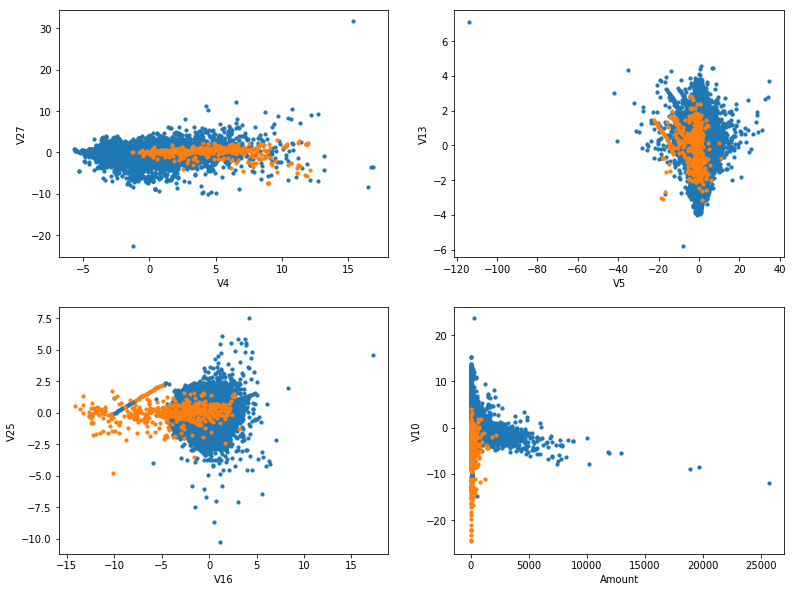

In [4]:
col_names = list(data.columns)[1:-1] ## TODO what is this?
tile_random_features(col_names, data)

### Prep data

In [5]:
train, test = train_test_split(data, test_size=0.2)

print '% of fraud cases in original, train, and test sets:'
print len(fradulent)*1.0/len(data)
print len(train[train['Class']==1])*1.0/len(train)
print len(test[test['Class']==1])*1.0/len(test)

% of fraud cases in original, train, and test sets:
0.00172748563062
0.00165024468389
0.00203644534953


In [6]:
# Split into features / class labels
train_x, train_y = [df.as_matrix() for df in split_class(train)]
test_x, test_y = [df.as_matrix() for df in split_class(test)]

## Performance Metrics

Note that a dumb majority class classifier has incredible accuracy!

In [7]:
from sklearn.metrics import accuracy_score
bs_pred = np.zeros(test_y.shape)
accuracy_score(test_y, bs_pred)

0.99796355465046871

That's hard to beat!

However what we really care about is not primarily accurancy. We want high recall so that we can find as much fraud ass possible while not creating _too_ many false positives

In [8]:
from sklearn.metrics import recall_score
print "Recall:"
recall_score(test_y, bs_pred)

Recall:


0.0

Recall is quite bad, making this a very poor classifier for finding fraud

Thus we will try to find a sampling methods that has good recall and better-than-horrible precision (or alternatively, high accurancy).

## Sampling methods

We are going to use Logistic Regression because it was the best performing classifiers according to preliminary exploration.

In [9]:
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier

In [10]:
# best results from hyper parameter search
# don;t bother with this!
C_best = 0.001
logit_params          = {}#'penalty': 'l2', 'C': C_best}
logit_params_balanced = {'class_weight':'balanced'}

In [11]:
models = []
labels = []

### Baseline

In [12]:
baseline = run_model(LogisticRegression, train_x, train_y, test_x, test_y, **logit_params)
models.append(baseline)
labels.append('Baseline')

---LogisticRegression---
Classification Report:
             precision    recall  f1-score   support

          0       1.00      1.00      1.00     56846
          1       0.76      0.52      0.62       116

avg / total       1.00      1.00      1.00     56962

Geometric mean:	0.719074751633


The baseline is pretty poor with regard to geometric mean. Recall for the majority class is great of course, but not so great for the minorty class

### Over sampling

In [13]:
from imblearn.over_sampling import RandomOverSampler
train_x_res, train_y_res = RandomOverSampler().fit_sample(train_x, train_y)
print_class_counts(train_y_res)

Class counts:
[(0, 227469), (1, 227469)]


In [14]:
resampled = run_model_sampler(RandomOverSampler, LogisticRegression, train_x, train_y, test_x, test_y, **logit_params)
models.append(resampled)
labels.append('Oversampling')

Sampler: RandomOverSampler,  Model: LogisticRegression
---LogisticRegression---
Classification Report:
             precision    recall  f1-score   support

          0       1.00      0.98      0.99     56846
          1       0.08      0.86      0.14       116

avg / total       1.00      0.98      0.99     56962

Geometric mean:	0.918698788288


### Under sampling

In [15]:
from imblearn.under_sampling import RandomUnderSampler
train_x_res, train_y_res = RandomUnderSampler().fit_sample(train_x, train_y)
print_class_counts(train_y_res)

Class counts:
[(0, 376), (1, 376)]


In [16]:
resampled = run_model_sampler(RandomUnderSampler, LogisticRegression, train_x, train_y, test_x, test_y, **logit_params)
models.append(resampled)
labels.append('Undersampling')

Sampler: RandomUnderSampler,  Model: LogisticRegression
---LogisticRegression---
Classification Report:
             precision    recall  f1-score   support

          0       1.00      0.96      0.98     56846
          1       0.05      0.88      0.09       116

avg / total       1.00      0.96      0.98     56962

Geometric mean:	0.92063533292


### SMOTE/ADASYN oversampling

In [17]:
from imblearn.over_sampling import SMOTE, ADASYN
train_x_res, train_y_res = SMOTE(kind='regular').fit_sample(train_x, train_y)
print_class_counts(train_y_res)

Class counts:
[(0, 227469), (1, 227469)]


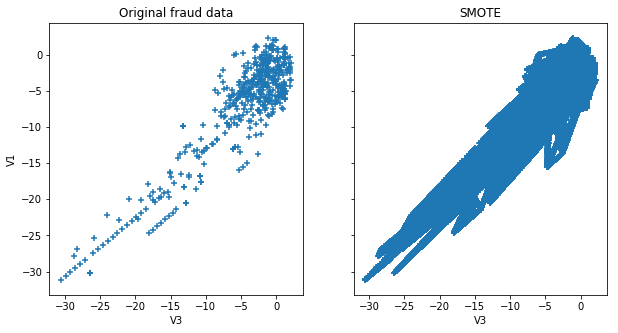

In [18]:
minorty = train_x_res[train_y_res == 1]
col_names = fradulent.columns
cols = (1,3)
marker = '+'

stack_vert = False
size = [5,10]
fig_args = [2,1] 

if not stack_vert:
    size = size[::-1]
    fig_args = fig_args[::-1]
    
fig_kwargs = {'sharex':stack_vert, 'sharey':(not stack_vert), 'figsize':size}
fig, axarr = plt.subplots(*fig_args, **fig_kwargs)
ax_orig = axarr[0]
ax_smote = axarr[1]

ax_orig.scatter(fradulent[col_names[cols[0]]],fradulent[col_names[cols[1]]], marker=marker)
ax_orig.set_title('Original fraud data')
ax_orig.set_ylabel(col_names[cols[0]])
ax_orig.set_xlabel(col_names[cols[1]])

ax_smote.scatter(minorty[:,cols[0]], minorty[:,cols[1]], marker=marker)
ax_smote.set_title('SMOTE')
ax_smote.set_xlabel(col_names[cols[1]])

plt.show()

In [19]:
resampled = run_model_sampler(SMOTE, LogisticRegression, train_x, train_y, test_x, test_y, **logit_params)
models.append(resampled)
labels.append('SMOTE')

Sampler: SMOTE,  Model: LogisticRegression
---LogisticRegression---
Classification Report:
             precision    recall  f1-score   support

          0       1.00      0.99      0.99     56846
          1       0.13      0.86      0.22       116

avg / total       1.00      0.99      0.99     56962

Geometric mean:	0.922857401256


In [20]:
resampled = run_model_sampler(ADASYN, LogisticRegression, train_x, train_y, test_x, test_y, **logit_params)
models.append(resampled)
labels.append('ADASYN')

Sampler: ADASYN,  Model: LogisticRegression
---LogisticRegression---
Classification Report:
             precision    recall  f1-score   support

          0       1.00      0.97      0.99     56846
          1       0.06      0.88      0.12       116

avg / total       1.00      0.97      0.98     56962

Geometric mean:	0.925169044261


### Model weights

In [21]:
balanced = run_model(LogisticRegression, train_x, train_y, test_x, test_y, **logit_params_balanced)
models.append(balanced)
labels.append('Weighted')

---LogisticRegression---
Classification Report:
             precision    recall  f1-score   support

          0       1.00      0.98      0.99     56846
          1       0.08      0.89      0.15       116

avg / total       1.00      0.98      0.99     56962

Geometric mean:	0.932335555375


###  Ranking Performance

In [27]:
from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score, average_precision_score, make_scorer
from imblearn.metrics import geometric_mean_score

def build_df(models, labels):
    get_model_vals = lambda metric: np.array([metric(test_y,m.predict(test_x)) for m in models])

    metrics = pd.DataFrame(index=labels)
    raw = np.vstack([get_model_vals(accuracy_score),
                     get_model_vals(recall_score),
                     get_model_vals(geometric_mean_score)]).T

    metrics['accuracy']  = raw[:,0]
    metrics['recall']    = raw[:,1]
    metrics['geometric'] = raw[:,2]

    return metrics

metrics = build_df(models, labels)
metrics

,accuracy,recall,geometric
Baseline,0.998683,0.517241,0.719075
Oversampling,0.978810,0.862069,0.918699
Undersampling,0.963730,0.879310,0.920635
SMOTE,0.987676,0.862069,0.922857
ADASYN,0.973228,0.879310,0.925169
Weighted,0.978775,0.887931,0.932336


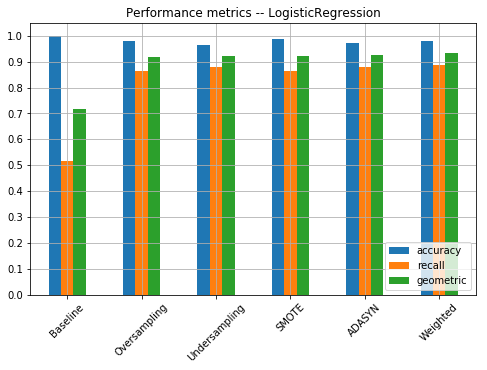

In [45]:
bar_plot(metrics, get_class_name(models[0]))

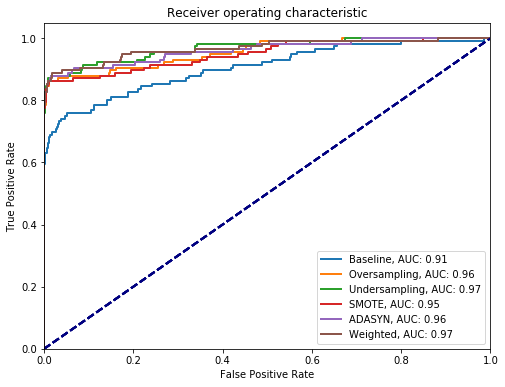

In [29]:
plot_many_roc(models, labels, test_x, test_y)

All the methods solidly outperform the baseline, though for the most part their performance is hard to distinguish from each other here. 

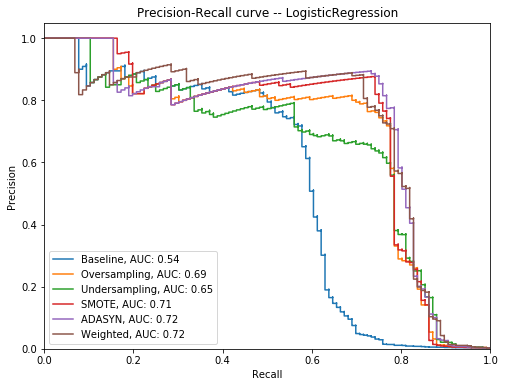

In [30]:
plot_many_pr(models, labels, test_x, test_y, title=get_class_name(models[0]))

SMOTE and ADASYN have the high AUC scores, although many seem to perform similarly in the high-recall/low precision region we would choose to operate in. Class balanced model and oversampling follow.

### Let's try for other classifiers

In [31]:
def build_models_labels(Model):
    # create function to preserve namespace
    models = []
    labels = []

    baseline = run_model(Model, train_x, train_y, test_x, test_y, verbose=False)
    models.append(baseline)
    labels.append('Baseline')
    # oversampling
    resampled = run_model_sampler(RandomOverSampler, Model, train_x, train_y, test_x, test_y, verbose=False)
    models.append(resampled)
    labels.append('Oversampling')
    # undersampling
    resampled = run_model_sampler(RandomUnderSampler, Model, train_x, train_y, test_x, test_y, verbose=False)
    models.append(resampled)
    labels.append('Undersampling')
    # SMOTE
    resampled = run_model_sampler(SMOTE, Model, train_x, train_y, test_x, test_y, verbose=False)
    models.append(resampled)
    labels.append('SMOTE')
    # ADASYN
    resampled = run_model_sampler(ADASYN, Model, train_x, train_y, test_x, test_y, verbose=False)
    models.append(resampled)
    labels.append('ADASYN')
    # Thresholding?
    
    
    return models, labels
    
model_groups = {}
model_groups['logit'] = (models, labels)
model_groups['qda']   = build_models_labels(QuadraticDiscriminantAnalysis)
model_groups['tree']  = build_models_labels(DecisionTreeClassifier)
model_groups['forest']  = build_models_labels(RandomForestClassifier)

Sampler: RandomOverSampler,  Model: QuadraticDiscriminantAnalysis
Sampler: RandomUnderSampler,  Model: QuadraticDiscriminantAnalysis
Sampler: SMOTE,  Model: QuadraticDiscriminantAnalysis
Sampler: ADASYN,  Model: QuadraticDiscriminantAnalysis
Sampler: RandomOverSampler,  Model: DecisionTreeClassifier
Sampler: RandomUnderSampler,  Model: DecisionTreeClassifier
Sampler: SMOTE,  Model: DecisionTreeClassifier
Sampler: ADASYN,  Model: DecisionTreeClassifier
Sampler: RandomOverSampler,  Model: RandomForestClassifier
Sampler: RandomUnderSampler,  Model: RandomForestClassifier
Sampler: SMOTE,  Model: RandomForestClassifier
Sampler: ADASYN,  Model: RandomForestClassifier


#### Special cases

In [32]:
tree = DecisionTreeClassifier(class_weight='balanced').fit(train_x, train_y)
model_groups['tree'][0].append(tree)
model_groups['tree'][1].append('Weighted')

Collect metrics into dataframes and plot

In [33]:
metrics_groups = {name: build_df(*group) for (name,group) in model_groups.items()}

In [34]:
metrics_groups['qda']

,accuracy,recall,geometric
Baseline,0.975984,0.836207,0.903528
Oversampling,0.966873,0.853448,0.908501
Undersampling,0.938942,0.879310,0.908696
SMOTE,0.974193,0.844828,0.907330
ADASYN,0.963836,0.870690,0.916170


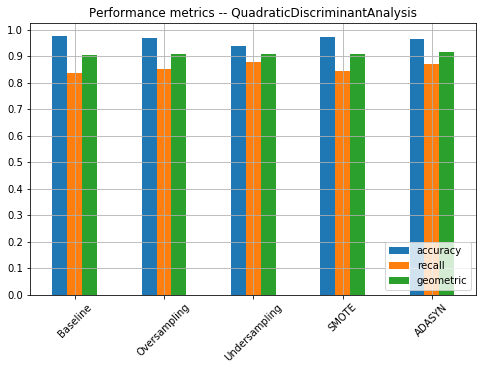

In [71]:
bar_plot(metrics_groups['qda'], get_class_name(model_groups['qda'][0]))

In [36]:
metrics_groups['tree']

,accuracy,recall,geometric
Baseline,0.999052,0.775862,0.880613
Oversampling,0.999017,0.732759,0.855825
Undersampling,0.924318,0.879310,0.901578
SMOTE,0.997823,0.775862,0.880071
ADASYN,0.987904,0.775862,0.875679
Weighted,0.998964,0.724138,0.850761


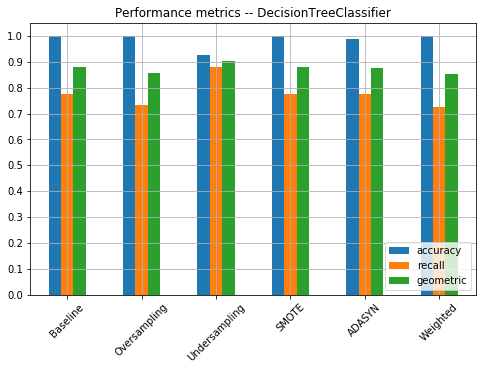

In [46]:
bar_plot(metrics_groups['tree'], get_class_name(model_groups['tree'][0]))

In [38]:
metrics_groups['forest']

,accuracy,recall,geometric
Baseline,0.999315,0.706897,0.840734
Oversampling,0.999350,0.741379,0.860981
Undersampling,0.971086,0.862069,0.915060
SMOTE,0.999333,0.793103,0.890454
ADASYN,0.999034,0.810345,0.899930


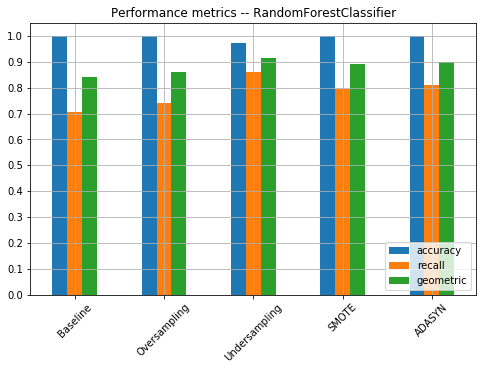

In [72]:
bar_plot(metrics_groups['forest'], get_class_name(model_groups['forest'][0]))

In [40]:
build_df(*model_groups['forest'])

,accuracy,recall,geometric
Baseline,0.999315,0.706897,0.840734
Oversampling,0.999350,0.741379,0.860981
Undersampling,0.971086,0.862069,0.915060
SMOTE,0.999333,0.793103,0.890454
ADASYN,0.999034,0.810345,0.899930


#### Precision Recall

In [47]:
def plot_pr_model_group(group):
    models = group[0]
    plot_many_pr(models, group[1], test_x, test_y, title=get_class_name(models[0]))

# plot_pr_model_group(model_groups['logit'])
# plot_pr_model_group(model_groups['qda'])
# plot_pr_model_group(model_groups['tree'])
# plot_pr_model_group(model_groups['forest'])

#### Thresholding

In [62]:
# thresh = .9
thresh_range = np.arange(0,1.,0.01)
qda_weighted = QuadraticDiscriminantAnalysis().fit(train_x, train_y)
probs_positive_class = qda_weighted.predict_proba(test_x)[:, 1]
# say default is the positive class and we want to make few false positives


acc_range = []
recall_range = []
gmean_range = []

for t in thresh_range:
    prediction = probs_positive_class > t
    acc_range.append(accuracy_score(test_y, prediction))
    recall_range.append(recall_score(test_y, prediction))
    gmean_range.append(geometric_mean_score(test_y, prediction))


    #     [m(test_y,prediction) for m in [accuracy_score, recall_score, geometric_mean_score]]

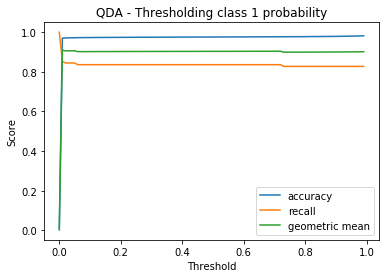

In [66]:
plt.figure()
plt.plot(thresh_range,acc_range,label='accuracy')
plt.plot(thresh_range,recall_range,label='recall')
plt.plot(thresh_range,gmean_range,label='geometric mean')
plt.xlabel('Threshold')
plt.ylabel('Score')
plt.legend(loc='lower right')
plt.title('QDA - Thresholding class 1 probability')
plt.show()

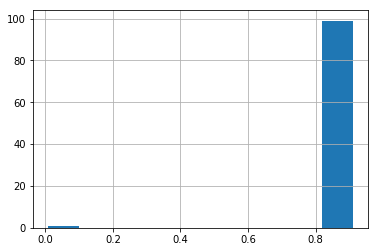

In [70]:
pd.Series(probs_positive_class).describe()
pd.Series(gmean_range).describe()
gmean = pd.Series(gmean_range)
gmean.hist()
plt.show()

In [24]:
# gms = [geometric_mean_score(test_y, m.predict(test_x)) for m in models]
# f1s = [f1_score(test_y, m.predict(test_x)) for m in models]

In [96]:
# cmap = plt.get_cmap('viridis')
# # cmap = plt.get_cmap('tab20')
# n = len(models)
# interval = len(cmap.colors)/n
# idxs = interval*np.ones(n).cumsum()
# colors = np.array(cmap.colors)[idxs.astype(int)]

In [97]:
# # colors = np.random.rand(len(models),3)
# plt.figure(figsize=(10,5))
# plt.bar(labels,gms,color=colors)
# plt.ylim([0.5,1])
# plt.title('Geometric Mean, sqtr(TPR * TNR)')
# plt.show()

# display({l:g for l,g in zip(labels,gms)})

As expected the baseline performance is bad by this metric, since geometric mean is representative metric for what we are trying to do: maximize both the TPR and TNR.

#### Conclusion

Based on the above plots we can conclude that all of the proposed methods are improvements on the baseline. SMOTE performs well in all plots, followed probably by ADASYN or the 'balanced' case. Balanced had a slightly better geometric mean, which is our primary metric, as well as in F1 Score; however ADASYN potentially outperformed balanced in the ROC and PR curves. Oversampling and undersampling appear to be inferior to other methods. Undersampling seems especially seems bad by the PR curve--perhaps this is explained by the fact that you are losing information to work with.